## Load the pipelines and make sentiment classification on the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
import bs4
import nltk.corpus  
from nltk.text import Text
import spacy
from pandarallel import pandarallel
import multiprocessing
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
widgets.IntSlider()

pd.set_option('max_colwidth', 200)

import sklearn
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics

from joblib import dump, load

2023-05-22 03:53:22.623923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 03:53:25.863512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-22 03:53:25.863694: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
pandarallel.initialize(nb_workers = 60, use_memory_fs = False)

INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Load the Data

In [3]:
%%time
df_sent = pd.read_parquet('data_to_sentiment.parquet', engine='pyarrow')
df_sent.head(2)

CPU times: user 49.9 s, sys: 9.39 s, total: 59.3 s
Wall time: 50.6 s


,date,month,year,quarter,day,dayofwk,title,text,title_clean,text_clean,title_tokens,text_tokens,title_len,text_len
0,2021-03-18,3,2021,2021Q1,18,3,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld...,Artificial intelligence improves parking efficiency Chinese cities People Daily Online,Artificial intelligence improves parking efficiency Chinese cities People Daily Online Home China Politics Foreign Affairs Opinions Video We Are China Business Military World Society Culture Trave...,"[Artificial, intelligence, improves, parking, efficiency, Chinese, cities, People, Daily, Online]","[Artificial, intelligence, improves, parking, efficiency, Chinese, cities, People, Daily, Online, Home, China, Politics, Foreign, Affairs, Opinions, Video, We, Are, China, Business, Military, Worl...",10,705
1,2020-02-27,2,2020,2020Q1,27,3,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\n...",Children With Autism Saw Their Learning Social Skills Boosted After Playing With This AI Robot News Parliament,"Children With Autism Saw Their Learning Social Skills Boosted After Playing With This AI Robot News Parliament Skip Thursday , February 27 , 2020 Latest Mansplaining conferences How forestall Drax...","[Children, With, Autism, Saw, Their, Learning, Social, Skills, Boosted, After, Playing, With, This, AI, Robot, News, Parliament]","[Children, With, Autism, Saw, Their, Learning, Social, Skills, Boosted, After, Playing, With, This, AI, Robot, News, Parliament, Skip, content, Thursday, February, 27, 2020, Latest, Mansplaining, ...",17,1208


In [4]:
!ls -l /home/jupyter/data/yelp/yelp_model/

total 1570960
-rw-r--r-- 1 jupyter jupyter 430818365 May 21 21:43 logreg.joblib
-rw-r--r-- 1 jupyter jupyter 747009306 May 21 21:30 nb.joblib
-rw-r--r-- 1 jupyter jupyter 430818618 May 21 21:47 svm.joblib


#### Load Models

In [5]:
path_yelp_model = '/home/jupyter/data/yelp/yelp_model/'

In [6]:
# Naive Bayes
%time clf_nb = load(os.path.join(path_yelp_model, 'nb.joblib'))

CPU times: user 38.8 s, sys: 2.8 s, total: 41.6 s
Wall time: 44.6 s


In [7]:
# Logistic Regression
%time clf_log = load(os.path.join(path_yelp_model, 'logreg.joblib'))

CPU times: user 39.5 s, sys: 2.22 s, total: 41.8 s
Wall time: 42.7 s


In [8]:
# Support Vector Machine
%time clf_svm = load(os.path.join(path_yelp_model, 'svm.joblib'))

CPU times: user 39.3 s, sys: 2.15 s, total: 41.5 s
Wall time: 42.5 s


In [9]:
df_sent.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181958 entries, 0 to 200331
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          181958 non-null  datetime64[ns]
 1   month         181958 non-null  int64         
 2   year          181958 non-null  int64         
 3   quarter       181958 non-null  period[Q-DEC] 
 4   day           181958 non-null  int64         
 5   dayofwk       181958 non-null  int64         
 6   title         181958 non-null  object        
 7   text          181958 non-null  object        
 8   title_clean   181958 non-null  object        
 9   text_clean    181958 non-null  object        
 10  title_tokens  181958 non-null  object        
 11  text_tokens   181958 non-null  object        
 12  title_len     181958 non-null  int64         
 13  text_len      181958 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(6), period[Q-DEC](1)
memory usage:

#### Make Classifications using the models loaded

In [10]:
content = df_sent['text_clean']

### Naive Bayes

In [11]:
%%time 
y_pred_nb = clf_nb.predict(content)

CPU times: user 6min 14s, sys: 1.23 s, total: 6min 15s
Wall time: 6min 15s


In [12]:
df_sent['sent_nb'] = y_pred_nb

### Logistic Regression

In [13]:
%%time 
y_pred_log = clf_log.predict(content)

CPU times: user 6min 21s, sys: 1.19 s, total: 6min 22s
Wall time: 6min 22s


In [14]:
df_sent['sent_log'] = y_pred_log

### SVM

In [15]:
%%time 
y_pred_svm = clf_svm.predict(content)

CPU times: user 6min 23s, sys: 1.17 s, total: 6min 24s
Wall time: 6min 24s


In [16]:
df_sent['sent_svm'] = y_pred_svm

### Model Comparisions

In [17]:
df_sent['sent_nb'].value_counts()

sent_nb
0    177851
1      4107
Name: count, dtype: int64

In [18]:
df_sent['sent_log'].value_counts()

sent_log
0    112304
1     69654
Name: count, dtype: int64

In [19]:
df_sent['sent_svm'].value_counts()

sent_svm
0    111753
1     70205
Name: count, dtype: int64

In [20]:
sent_comp = pd.DataFrame({"Sentiment": [0,1],
                          "Naive Bayes": df_sent['sent_nb'].value_counts(),
                         "Logistic Regression": df_sent['sent_log'].value_counts(),
                         "SVM": df_sent['sent_svm'].value_counts()})
sent_comp

,Sentiment,Naive Bayes,Logistic Regression,SVM
0,0,177851,112304,111753
1,1,4107,69654,70205


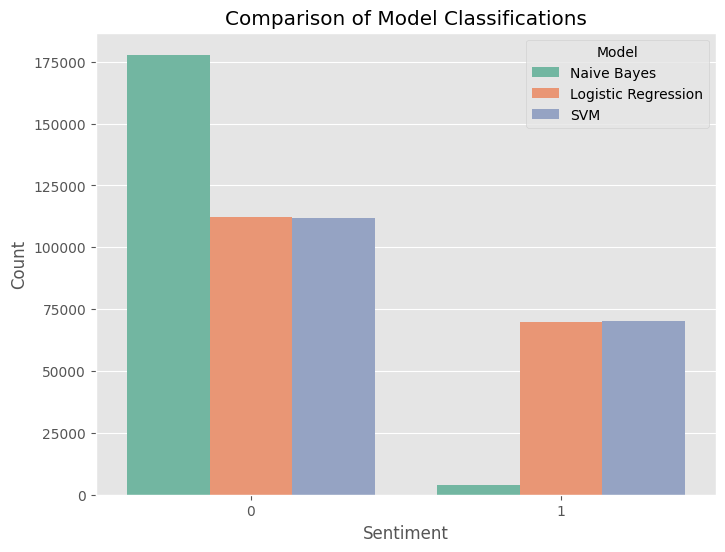

In [21]:
sent_comp_melted = sent_comp.melt('Sentiment', var_name='Model', value_name='Count')

plt.figure(figsize=(8, 6))
plt.style.use("ggplot")
sns.barplot(data=sent_comp_melted, x='Sentiment', y='Count', hue='Model', palette = "Set2")
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Comparison of Model Classifications')
plt.legend(title='Model')
plt.show()

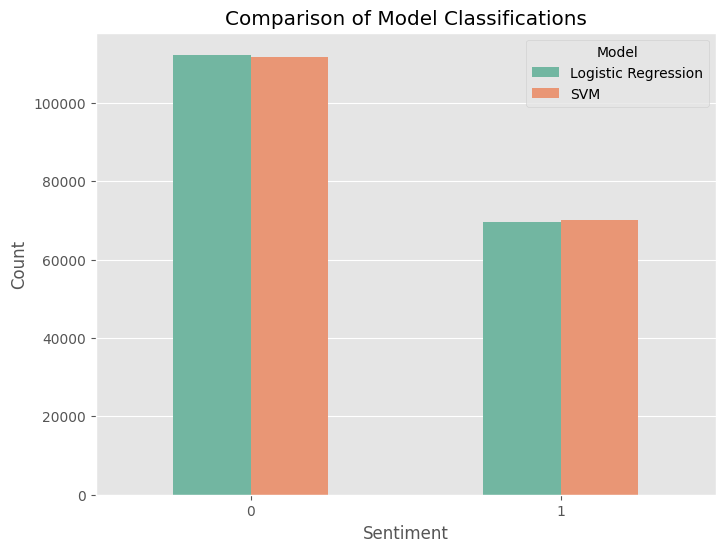

In [22]:
## Drop the Naive Bayes since its totally skewed and did not predict well
sent_comp_melted = sent_comp_melted[sent_comp_melted["Model"]!= "Naive Bayes"]

plt.figure(figsize=(8, 6))
plt.style.use("ggplot")
sns.barplot(data=sent_comp_melted, x='Sentiment', y='Count', hue='Model', palette = "Set2", width = 0.5)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Comparison of Model Classifications')
plt.legend(title='Model')
plt.show()

In [23]:
pd.set_option('display.max_colwidth',900)
df_sent[df_sent['sent_log'] != df_sent['sent_svm']][['text_clean', 'sent_log','sent_svm']].head(5)


,text_clean,sent_log,sent_svm
0,"Artificial intelligence improves parking efficiency Chinese cities People Daily Online Home China Politics Foreign Affairs Opinions Video We Are China Business Military World Society Culture Travel Science Sports Photo Languages Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday , March 18 , 2021 Home Artificial intelligence improves parking efficiency Chinese cities By LiuShiyao People Daily 09 16 , March 18 , 2021 Photo taken July 1 , 2019 , shows sign electronic toll collection ETC newly set roadside parking space Yangzhuang road , Shijingshan district , Beijing . Some urban areas city started use ETC system roadside parking spaces July 1 , 2019 . Peoples Daily Online Li Wenming Thanks application artificial intelligence AI empowered roadside electronic toll collection ETC system , Chinas city Beijing seen significant improvement efficiency parking fe...",1,0
22,"Global Artificial Intelligence Software Market 2019 Sales Revenue , Cost , Import Export Analysis , Margin 2024 Market Research Gazette February 17 , 2020 Authors Contact Us About Us Market Research Gazette ChemicalsEnergyHealthcareHeavy IndustryITMaterialsContact Us Global Anisotropic Conductive Paste Market 2019 2025 Growth Analysis , Business Opportunities , Advance Technology Application Segmentation By Leading Global Vendor Global Concentrated Solar Power Market expand whopping CAGR 20.30 20142020 Boron Nitride Boat Market Capacity , Production , Revenue Forecast 2019 2024 Overview BIPV Market Size , Trends , Share , Regional Outlook Growth Forecast till 2024 Smart Parking Solutions Market 2019 Global Analysis , Opportunities Forecast 2025 Global Palmitic Acid Market Overview Demographic Data Industry Growth Trends 2018 2023 Market Research Gazette ChemicalsEnergyHealthcareHeavy...",0,1
25,"One Punch Man fan imagined King reality thanks artificial intelligence Asap Land HomeAboutPrivacy PolicyCookie PolicyTerms UseTeamContact July 24 , 2020 HomeBusinessTechnologyGeneral NewsEntertainment One Punch Man fan imagined King reality thanks artificial intelligence Fortnite , Season complete challenges Week ONE PIECE charming Carrot protagonist faithful cosplay Nintendo interested new markets No longer video games World Warcraft Queen Azshara comes life Daniela Loveiras cosplay Formula canceled grand prizes Mexico , Brazil USA 2020 HomeBusinessTechnologyGeneral NewsEntertainment HomeBusinessTechnologyGeneral NewsEntertainment EntertainmentOne Punch Man fan imagined King reality thanks artificial intelligenceJuly 24 , 2020Add CommentMaria Rivera2 Min Read Maria RiveraAdd Comment Share Facebook Twitter PinterestArtificial intelligence increasingly global phenomenon . tool optimiz...",1,0
74,"Conversational AI Market Size COVID 19 Impact Analysis Forecast 2025 Eurowire Eurowire Contact home HomeNewsConversational AI Market Size COVID 19 Impact Analysis Forecast 2025 Conversational AI Market Size COVID 19 Impact Analysis Forecast 2025 Posted On January 20 , 2021 Posted By mukati Comments The global industrial valve expected record CAGR forecast period . The main factor driving research increasing demand power chemical industries . The stagnant industrial growth developed countries expected hinder growth research . The oil gas industry dominated expected experience growth forecast period oil gas activity grows globally . The increasing demand automatic valves serve opportunities future . Asia Pacific dominated worlds consuming markets countries China India . report Conversational AI Market available https www.orionmarketreports.com conversational ai platform 7902 Major Play...",0,1
76,"Bill Gates says AI currently important innovation battle Microsoft Google . ExBulletin Entertainment Politics Fashion Sports Tech Business Contact Us Connect ExBulletin Bill Gates says AI currently important innovation battle Microsoft Google . Entertainment Politics Fashion Sports Tech Business Contact Us Tech Bill Gates says AI

In [24]:
##Logistic Regression seems to be doing better in classification than SVM
# df_sent.drop('sent_nb',axis =1, inplace=True)
df_sent.rename(columns = {'sent_log':'sentiment_score'}, inplace = True)
df_sent['sentiment'] = np.where(df_sent['sentiment_score']<1,"Negative","Positive")
df_sent.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'sent_nb', 'sentiment_score', 'sent_svm', 'sentiment'],
      dtype='object')

In [25]:
df_sent.head(2)

,date,month,year,quarter,day,dayofwk,title,text,title_clean,text_clean,title_tokens,text_tokens,title_len,text_len,sent_nb,sentiment_score,sent_svm,sentiment
0,2021-03-18,3,2021,2021Q1,18,3,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome>>\n\t\t\nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao (People's Daily) 09:16, March 18, 2021\nPhoto taken on July 1, 2019, shows a sign for electronic toll collection (ETC) newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. Some urban areas of the city started to use ETC system for roadside parking spaces since July 1, 2019. (People’s Daily Online/Li Wenming)\n\n\tThanks to the application of an artificial intelligence (AI)-empowered ro...",Artificial intelligence improves parking efficiency Chinese cities People Daily Online,"Artificial intelligence improves parking efficiency Chinese cities People Daily Online Home China Politics Foreign Affairs Opinions Video We Are China Business Military World Society Culture Travel Science Sports Photo Languages Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday , March 18 , 2021 Home Artificial intelligence improves parking efficiency Chinese cities By LiuShiyao People Daily 09 16 , March 18 , 2021 Photo taken July 1 , 2019 , shows sign electronic toll collection ETC newly set roadside parking space Yangzhuang road , Shijingshan district , Beijing . Some urban areas city started use ETC system roadside parking spaces July 1 , 2019 . Peoples Daily Online Li Wenming Thanks application artificial intelligence AI empowered roadside electronic toll collection ETC system , Chinas city Beijing seen significant improvement efficiency parking fe...","[Artificial, intelligence, improves, parking, efficiency, Chinese, cities, People, Daily, Online]","[Artificial, intelligence, improves, parking, efficiency, Chinese, cities, People, Daily, Online, Home, China, Politics, Foreign, Affairs, Opinions, Video, We, Are, China, Business, Military, World, Society, Culture, Travel, Science, Sports, Photo, Languages, Chinese, Japanese, French, Spanish, Russian, Arabic, Korean, German, Portuguese, Thursday, March, 18, 2021, Home, Artificial, intelligence, improves, parking, efficiency, Chinese, cities, By, LiuShiyao, People, Daily, 09, 16, March, 18, 2021, Photo, taken, July, 1, 2019, shows, sign, electronic, toll, collection, ETC, newly, set, roadside, parking, space, Yangzhuang, road, Shijingshan, district, Beijing, ., Some, urban, areas, city, started, use, ETC, system, roadside, parking, spaces, since, July, 1, 2019, ., Peoples, Daily, ...]",10,705,0,1,0,Positive
1,2020-02-27,2,2020,2020Q1,27,3,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in corporate paid leave policies\n\nNews Parliament\n\nGet the Real Story\n\n \nNews\nTechnology\nServices\nHealthcare\nWorld\nBusiness\nEntertainment\n \n\nWorld \n\n\n \t\t\tChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With Thi

In [26]:
%%time
## Save the Dataframe, and also separate the Postive and Negative sentiments and save them as well
df_sent.to_parquet('data_from_sentiment.parquet')
df_sent[df_sent['sentiment']=="Positive"].to_parquet('data_pos_sent.parquet')
df_sent[df_sent['sentiment']=="Negative"].to_parquet('data_neg_sent.parquet')

CPU times: user 1min 13s, sys: 15.6 s, total: 1min 29s
Wall time: 2min 2s


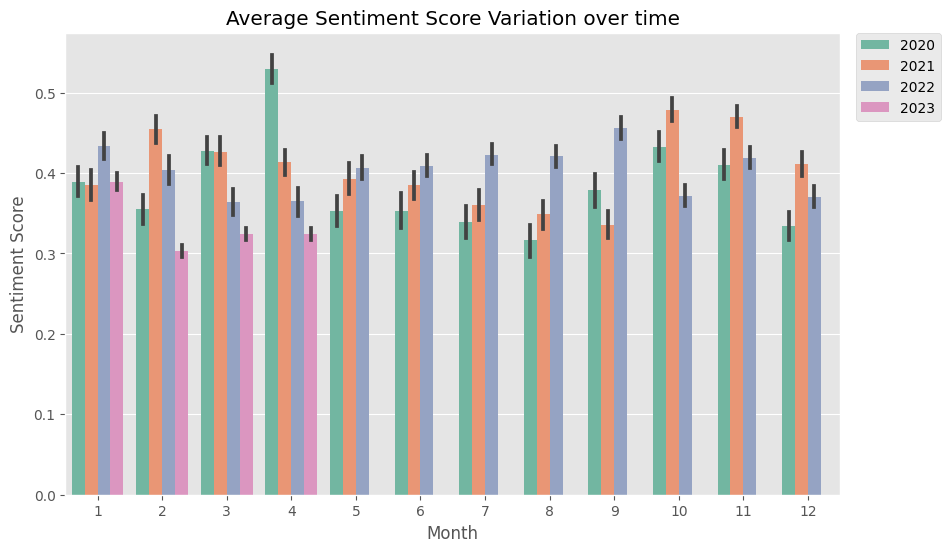

In [27]:
#Plot the variation of sentiments over time
#Plotting the sentiments over time
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data = df_sent, x = 'month', y= 'sentiment_score', hue = "year", palette = "Set2", ax=ax)
plt.legend(bbox_to_anchor=(1.02,1), loc=2, borderaxespad =0.)
plt.xlabel("Month")
plt.ylabel("Sentiment Score")
plt.title("Average Sentiment Score Variation over time")
plt.show()

Text(0.5, 1.0, 'Sentiment Variation Over Time')

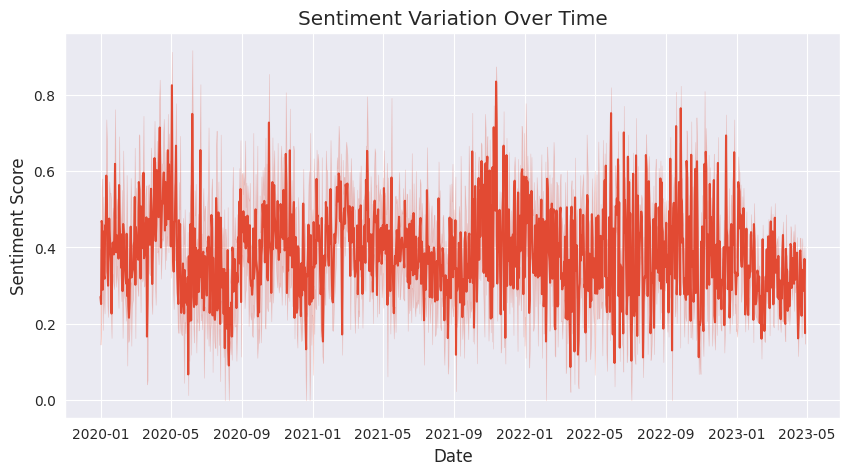

In [28]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.lineplot(data = df_sent, x='date', y= 'sentiment_score')
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Variation Over Time")

In [29]:
df_sent.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'sent_nb', 'sentiment_score', 'sent_svm', 'sentiment'],
      dtype='object')

Text(0.5, 1.0, 'Sentiment Variation Over Time')

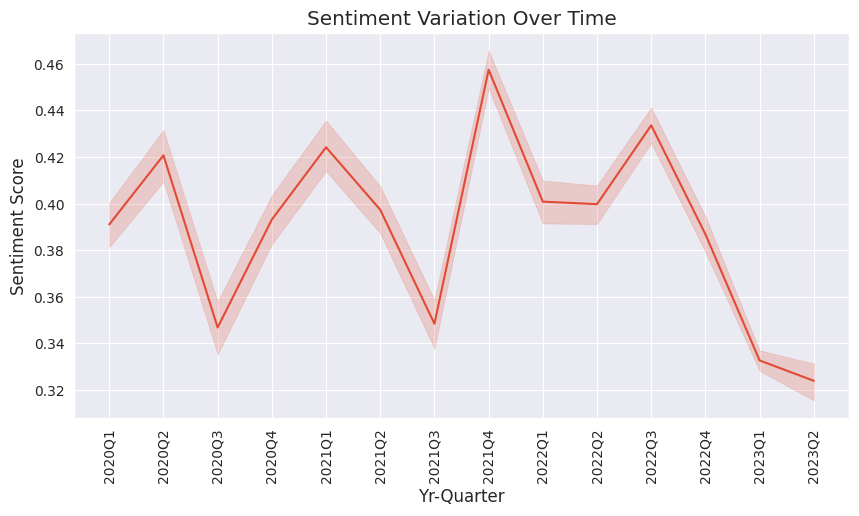

In [30]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
df_sent_sorted = df_sent.sort_values('quarter')  # Sort DataFrame by 'quarter' column
sns.lineplot(data = df_sent_sorted, x=df_sent_sorted['quarter'].astype('str'), y= 'sentiment_score')
plt.xlabel("Yr-Quarter")
plt.ylabel("Sentiment Score")
plt.xticks(rotation= 90)
plt.title("Sentiment Variation Over Time")


In [32]:
df_pos = pd.read_parquet('data_pos_sent.parquet', engine='pyarrow')
df_neg = pd.read_parquet('data_neg_sent.parquet', engine='pyarrow')

Text(0.5, 1.0, 'Positive Sentiment Variation Over Time')

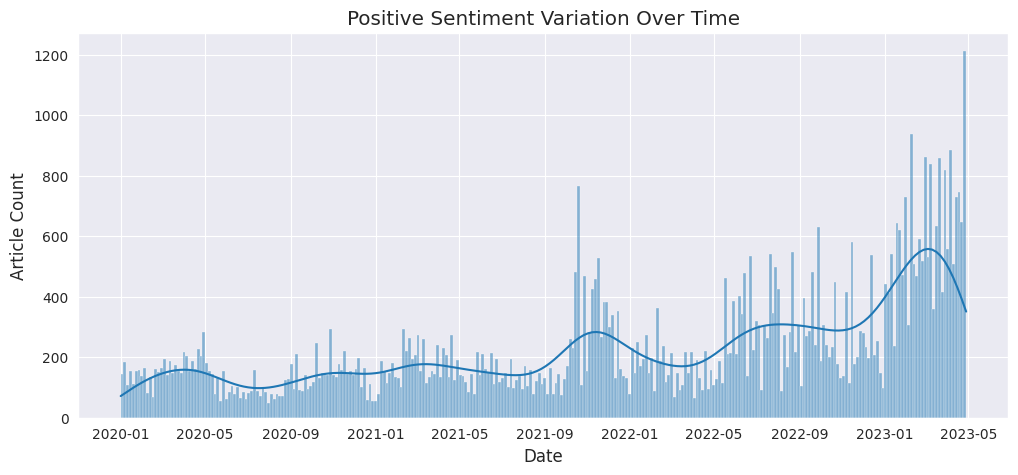

In [53]:
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.histplot(data = df_pos, x='date', kde=True, bins=300, color="tab:blue")
plt.xlabel("Date")
plt.ylabel("Article Count")
plt.title("Positive Sentiment Variation Over Time")

Text(0.5, 1.0, 'Negative Sentiment Variation Over Time')

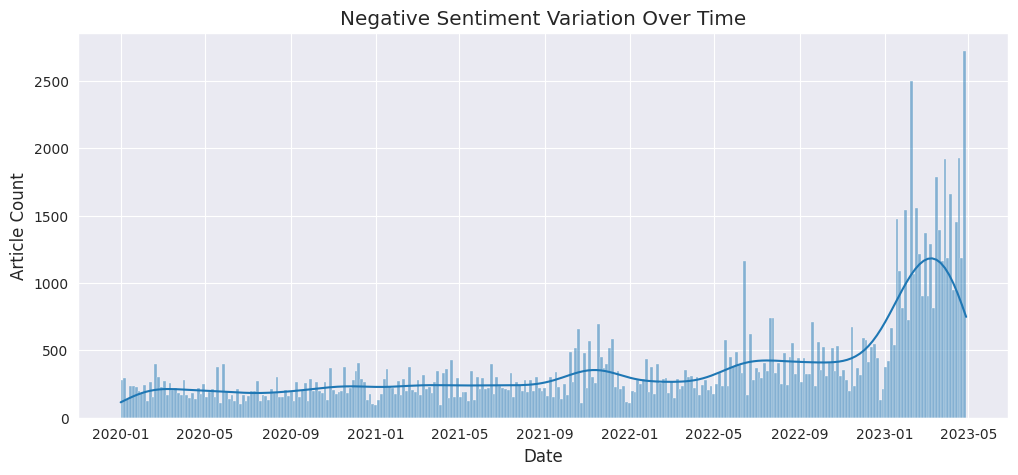

In [54]:
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.histplot(data = df_neg, x='date', kde=True, bins=300, color="tab:blue")
plt.xlabel("Date")
plt.ylabel("Article Count")
plt.title("Negative Sentiment Variation Over Time")

Text(0.5, 1.0, 'Quarterly Positive Sentiment Variation')

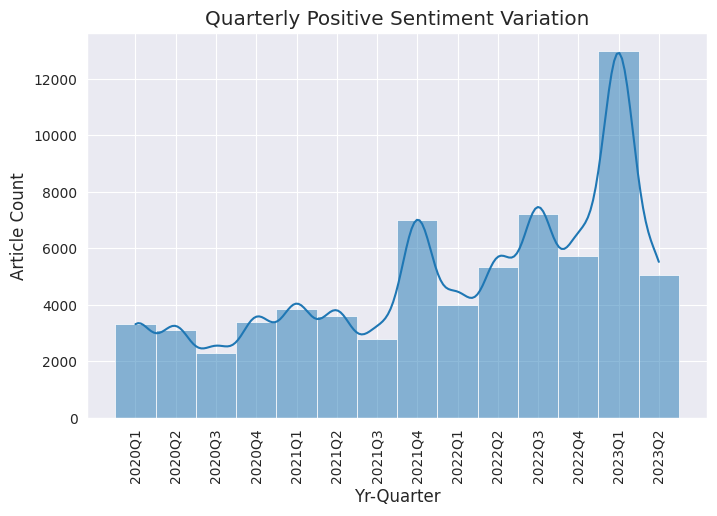

In [59]:
plt.figure(figsize=(8,5))
sns.set_style('darkgrid')
pos_sent_sorted = df_pos.sort_values('quarter')  # Sort DataFrame by 'quarter' column
sns.histplot(data = pos_sent_sorted, x=pos_sent_sorted['quarter'].astype('str'), kde=True, color="tab:blue")
plt.xlabel("Yr-Quarter")
plt.ylabel("Article Count")
plt.xticks(rotation=90)
plt.title("Quarterly Positive Sentiment Variation")

Text(0.5, 1.0, 'Quarterly Negative Sentiment Variation')

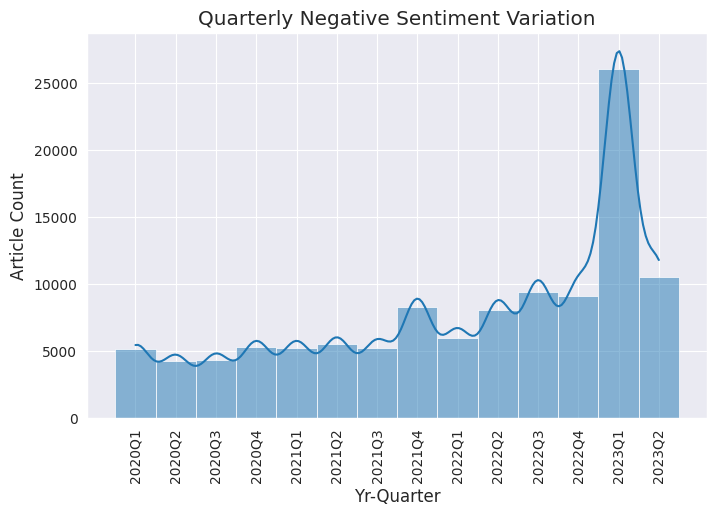

In [60]:
plt.figure(figsize=(8,5))
sns.set_style('darkgrid')
neg_sent_sorted = df_neg.sort_values('quarter')  # Sort DataFrame by 'quarter' column
sns.histplot(data = neg_sent_sorted, x=neg_sent_sorted['quarter'].astype('str'), kde=True, color="tab:blue")
plt.xlabel("Yr-Quarter")
plt.ylabel("Article Count")
plt.xticks(rotation=90)
plt.title("Quarterly Negative Sentiment Variation")

In [61]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Sun, 21 May 2023 23:42:00'